# **Data import**

In [107]:
import pandas as pd
import requests
from io import StringIO
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format

resp = requests.get('https://k-copart-car-price-prediction.s3.eu-north-1.amazonaws.com/data.csv')

if resp.status_code == 200:
  data = resp.text
else:
  print("can't fetch data")
  exit()

df = pd.read_csv(StringIO(data))

# **Data cleanup and datatype conversions**

Drop unused columns:

In [108]:
df = df[df.Sold == 'Sold']
df = df.drop(['Sold', 'Make', 'Engine', 'Special Note', 'Interior', 'Make', 'Manufactured In', 'Exterior'], axis=1)

Remove Duplicates:

In [109]:
df = df.drop_duplicates()
df[df.duplicated()]
df.shape

(282, 25)

Clean the data:

In [110]:
df = df[df.Odometer_km != 'unknown)']
df = df[df.Model != 'All Models']
df = df[df.Cylinders != 'All']

Data types conversions:

In [111]:
df.Model = df.Model.str.title()

df['Auction_date'] = pd.to_datetime(df['Auction_date'])

to_num = ['Year', 'Final_bid', 'Cylinders', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost', 'Eng_L', 'Eng_HP']

for _ in to_num:
  df[_] = pd.to_numeric(df[_])

Cleanup Actual cash value == 0 and Estimated repair cost

# **Dataset stats**

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 261 entries, 0 to 290
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Final_bid              261 non-null    int64         
 1   Seller                 261 non-null    object        
 2   Auction_date           261 non-null    datetime64[ns]
 3   Year                   261 non-null    int64         
 4   vin                    261 non-null    object        
 5   Loss                   261 non-null    object        
 6   Primary damage         261 non-null    object        
 7   Secondary damage       260 non-null    object        
 8   Start code             261 non-null    object        
 9   Key                    261 non-null    object        
 10  Body Style             172 non-null    object        
 11  Vehicle Class          138 non-null    object        
 12  Model                  261 non-null    object        
 13  Fuel Type 

In [113]:
df.describe()

,Final_bid,Auction_date,Year,Cylinders,Odometer_km,Actual_cash_value,Estimated_repair_cost,Eng_L,Eng_HP
count,261.00,261,261.00,145.00,261.00,261.00,261.00,260.00,145.00
mean,"4,928.71",2024-06-01 00:22:04.137931008,"2,013.94",4.52,"211,361.26","12,772.44","7,418.11",2.56,177.05
min,350.00,2024-05-30 00:00:00,"2,000.00",4.00,"1,184.00",0.00,0.00,1.50,73.00
25%,"1,850.00",2024-06-01 00:00:00,"2,010.00",4.00,"110,980.00","4,600.00",0.00,1.80,132.00
50%,"3,225.00",2024-06-01 00:00:00,"2,014.00",4.00,"213,336.00","10,769.00","4,506.00",2.50,176.00
75%,"6,975.00",2024-06-02 00:00:00,"2,018.00",4.00,"290,039.00","18,609.00","12,631.00",2.78,203.00
max,"25,900.00",2024-06-03 00:00:00,"2,024.00",8.00,"526,882.00","55,000.00","43,524.00",5.70,381.00
std,"4,500.96",NaN,5.48,1.08,"119,700.13","10,536.16","9,011.42",0.91,62.81


# **Data analysis**




## Actual cash value and Estimated repair cost

In [114]:
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")

[ACV = 0]: 30
[ERC = 0]: 123


Since for most cases there's no good explanation why Actual_cash_value = 0, it makes sense to clean up these rows so that other predictions will be more accurate

In [115]:
df = df[df['Actual_cash_value'] != 0]
print(f"[ACV = 0]: {(df['Actual_cash_value'] == 0).sum()}")
print(f"[ERC = 0]: {(df['Estimated_repair_cost'] == 0).sum()}")
print(df.shape)

[ACV = 0]: 0
[ERC = 0]: 93
(231, 25)


Makes sense to keep Estimated repair cost = 0 since it seem to have an explanation (e.g. when it's not clear what needs to be repaired)

## Models distribution

Clean and unify models:

In [116]:
df = df[df['Model'] != 'All Models']  # clearly a mistake

df.loc[df['Model'] == '4Runner Se', 'Model'] = '4Runner'
df.loc[df['Model'] == 'Camry Sola', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Grand Highlander', 'Model'] = 'Highlander'
df.loc[df['Model'] == 'Corolla Cr', 'Model'] = 'Corolla'
df.loc[df['Model'] == 'Camry Hybrid', 'Model'] = 'Camry'
df.loc[df['Model'] == 'Prius C', 'Model'] = 'Prius'
df.loc[df['Model'] == 'Avalon Hybrid', 'Model'] = 'Avalon'
df.loc[df['Model'] == 'Corolla (U.S.)', 'Model'] = 'Corolla'

In [117]:
models_df = df.groupby('Model', as_index=False).agg({'Final_bid': pd.Series.mean,
                         'Auction_date': pd.Series.count,
                        'Actual_cash_value': pd.Series.mean})

models_df = models_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

models_df

,Model,Avg_final_bid,Count,Avg_actual_cash_value
4,Corolla,"3,898.84",61,"11,384.51"
3,Camry,"3,435.96",56,"10,458.36"
7,Prius,"2,778.61",28,"10,452.71"
8,Rav4,"6,826.14",22,"19,410.55"
5,Highlander,"6,358.93",14,"17,837.36"
12,Tacoma,"8,157.69",13,"27,669.77"
0,4Runner,"12,056.82",11,"26,903.27"
13,Tundra,"9,540.00",5,"23,060.20"
11,Sienna,"5,368.75",4,"14,147.00"
1,Avalon,"3,758.33",3,"15,763.67"


In [139]:
import plotly.express as px

bar = px.bar(x = models_df.Model,
             y = models_df.Count,
             title='Distribution of models in dataset',
             hover_name=models_df.Model,
             color=models_df.Avg_final_bid,
             color_continuous_scale='Agsunset')

bar.update_layout(xaxis_title='Model',
yaxis_title='Amount of cars in the dataset',
coloraxis_showscale=False)

bar.show()

Range of bids by model:

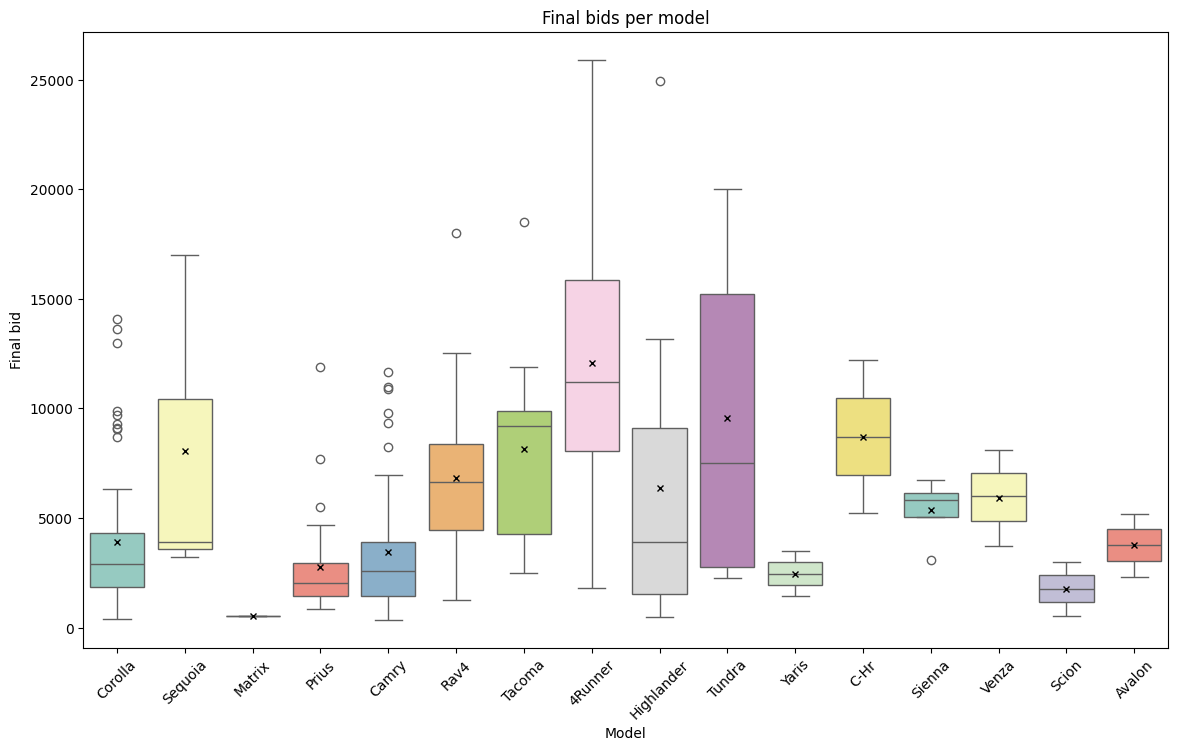

In [143]:
# box = px.box(df,
#              y='Model',
#              x='Final_bid',
#             #  notched=True,
#             #  points='all',
#              title='Final bids per model')

# # box.update_layout(yaxis=dict(type='log'))

# box.show()


plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Model',
    y='Final_bid',
    palette='Set3',  # Color palette
    showmeans=True,  # Show the mean as a point
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}  # Mean marker properties
)


plt.title('Final bids per model', fontsize=12)
plt.xlabel('Model', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

## Distribution by damage

In [120]:
damage_df = df.groupby('Primary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

damage_df = damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count', 'Avg_final_bid'], ascending=False)

damage_df

,Primary damage,Avg_final_bid,Count,Avg_actual_cash_value
4,Front end,"4,674.95",100,"14,648.55"
13,Rear,"5,330.00",20,"14,612.05"
3,Front & rear,"4,121.15",13,"13,256.15"
9,Left side,"4,001.92",13,"13,042.38"
23,Unknown,"1,978.85",13,"5,211.46"
19,Side,"7,242.33",12,"18,573.50"
0,All over,"12,734.38",8,"28,598.88"
17,Right side,"6,716.67",6,"18,515.50"
10,Mechanical,"1,477.67",6,"4,965.50"
18,Rollover,"5,805.00",5,"28,078.60"


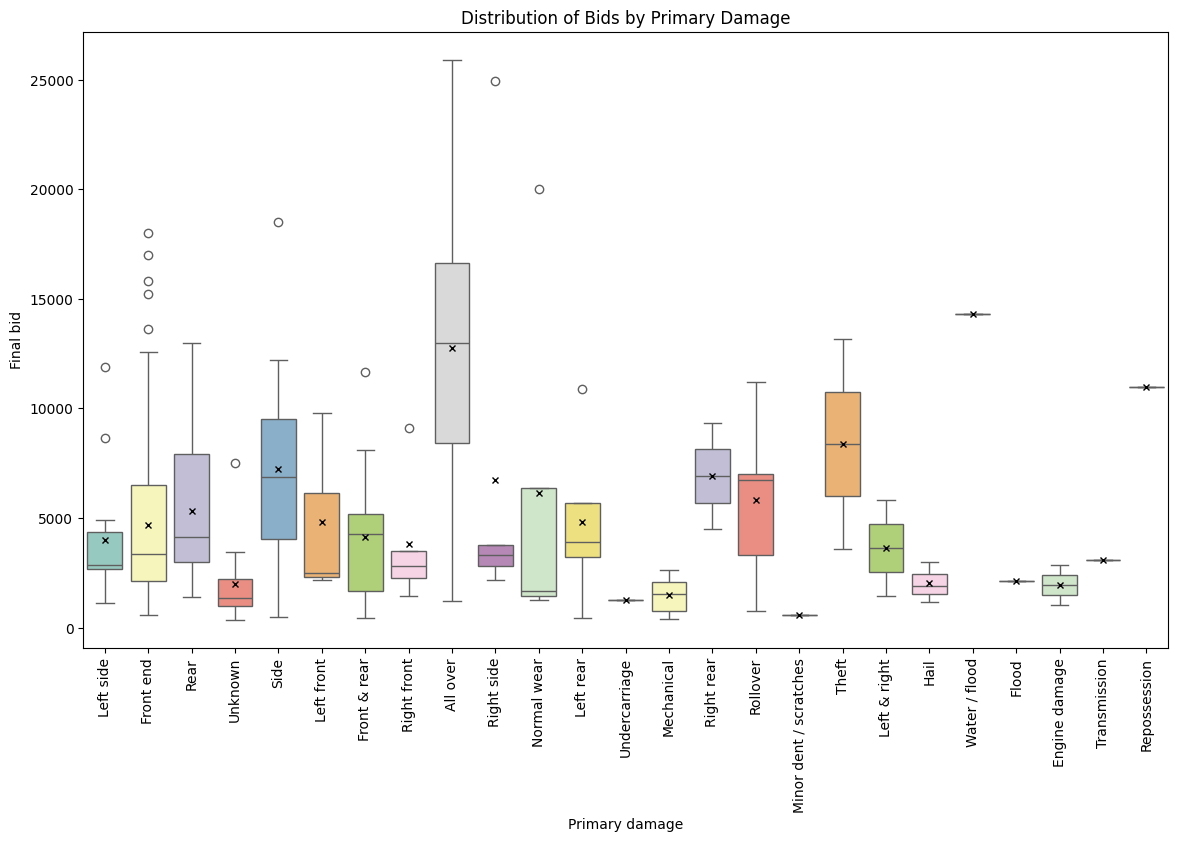

In [146]:
plt.figure(figsize=(14, 8))

box = sns.boxplot(
    data=df,
    x='Primary damage',
    y='Final_bid',
    palette='Set3',  # Color palette
    showmeans=True,  # Show the mean as a point
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}  # Mean marker properties
)


plt.title('Distribution of Bids by Primary Damage', fontsize=12)
plt.xlabel('Primary damage', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
plt.xticks(rotation=90)
# plt.grid(True)

plt.show()

<h3>Secondary damage:</h3>

In [122]:
sec_damage_df = df.groupby('Secondary damage', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sec_damage_df = sec_damage_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sec_damage_df

,Secondary damage,Avg_final_bid,Count,Avg_actual_cash_value
0,-,"5,021.34",107,"14,277.01"
22,Unknown,"4,481.00",25,"12,317.16"
11,Minor dent / scratches,"5,599.38",13,"12,698.38"
18,Side,"4,104.17",12,"14,368.25"
4,Front end,"5,040.00",10,"14,152.20"
15,Right side,"3,802.78",9,"13,536.56"
12,Rear,"7,450.12",8,"23,942.88"
19,Suspension,"6,225.00",6,"15,790.17"
10,Mechanical,"2,968.60",5,"10,884.60"
6,Left & right,"4,515.00",5,"12,865.20"


In [123]:
burst_df = df.groupby(by=['Primary damage', 'Secondary damage'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Primary damage', 'Secondary damage'],
                    values='Count',
                    title='Damage types',
                   )

burst.show()

**<h2>Conclusion regarding damage:</h2>**

* Front end is amazingly popular damage
* Front end damage is cheaper than Rear damage
* Left side damage is cheaper (and twice more frequent!) than Right side

> Check if it makes sense to merge all Front together, all Rear together and all Side together

> Cars with "All over" and "Rollover" damages are rather expensive for unclear reason  [To be investigated]




## Distribution by Sellers

In [124]:
sellers_df = df.groupby('Seller', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

sellers_df = sellers_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

sellers_df

,Seller,Avg_final_bid,Count,Avg_actual_cash_value
22,Progressive Casualty Insurance,"4,636.21",58,"15,441.40"
19,Non-insurance company,"4,282.86",57,"10,320.63"
13,Insurance company,"5,781.14",29,"15,740.21"
23,State Farm Group Insurance,"4,258.33",18,"14,475.06"
9,Farmers Insurance,"4,013.64",11,"15,266.45"
21,Progressive,"5,776.55",11,"17,821.73"
24,State Farm Insurance,"3,530.67",9,"15,827.89"
10,Geico Insurance,"5,440.00",5,"15,313.20"
27,Trexis Insurance,"8,756.25",4,"20,487.00"
12,Insurance Company,"5,862.50",4,"13,013.25"


**Conclusion:** taking aside sellers with very few lots, there seem to be no difference among major insurance companies. However, "non-insurance company" sells cars ~30% cheaper. Interesting

## Distribution by Manufacturing Year

In [125]:
year_df = df.groupby('Year', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

year_df = year_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

year_df

,Year,Avg_final_bid,Count,Avg_actual_cash_value
13,2014,"3,715.45",20,"11,029.45"
9,2010,"2,078.31",16,"7,298.56"
16,2017,"5,434.53",15,"16,307.80"
14,2015,"4,361.67",15,"14,070.20"
11,2012,"2,681.67",15,"9,928.80"
12,2013,"3,366.07",14,"12,159.21"
17,2018,"7,096.43",14,"20,348.57"
18,2019,"8,988.46",13,"23,130.92"
19,2020,"6,703.92",13,"20,741.38"
20,2021,"9,185.42",12,"30,014.58"


In [126]:
hist = px.histogram(year_df,
                   x='Year',
                    y = 'Count',
                  #  color='Avg_final_bid',
                   nbins=24,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',
                   marginal='box',
                    )

hist.update_layout(xaxis_title='Year',
                   yaxis_title='Count',)

hist.show()

## Distribution by start code:

In [127]:
code_df = df.groupby('Start code', as_index=False).agg({'Final_bid': pd.Series.mean,
                                                       'Auction_date': pd.Series.count,
                                                       'Actual_cash_value': pd.Series.mean})

code_df = code_df.rename(columns = {'Final_bid' : 'Avg_final_bid'}).rename(columns = {'Auction_date' : 'Count'}).rename(columns = {'Actual_cash_value' : 'Avg_actual_cash_value'}).sort_values(['Count'], ascending=False)

code_df

,Start code,Avg_final_bid,Count,Avg_actual_cash_value
1,Run and Drive,"5,246.52",165,"14,519.05"
3,Stationary,"3,906.67",30,"14,332.87"
2,Starts,"4,346.58",24,"13,613.46"
0,No information,"4,322.73",11,"15,381.18"


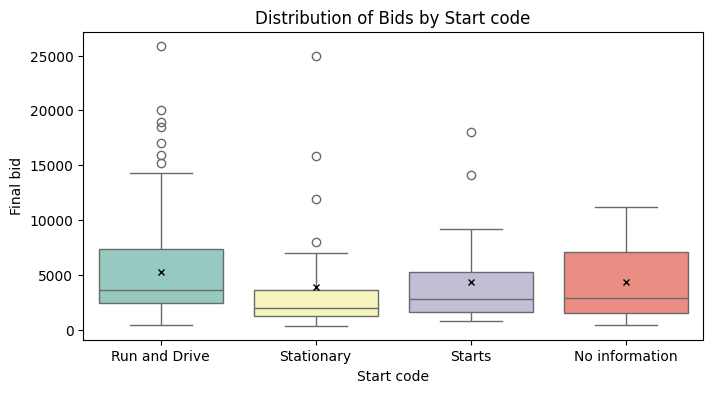

In [149]:
plt.figure(figsize=(8, 4))

box = sns.boxplot(
    data=df,
    x='Start code',
    y='Final_bid',
    palette='Set3',  # Color palette
    showmeans=True,  # Show the mean as a point
    meanprops={"marker":"x", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"5"}  # Mean marker properties
)


plt.title('Distribution of Bids by Start code', fontsize=12)
plt.xlabel('Start code', fontsize=10)
plt.ylabel('Final bid', fontsize=10)
# plt.xticks(rotation=45)
# plt.grid(True)

plt.show()

## Distribution by Mileage:

In [128]:
hist = px.histogram(df,
                   x='Odometer_km',
                  #  nbins=20,
                   opacity=0.6,
                  #  barmode='overlay',
                  #  histnorm='percent',

                    )

hist.update_layout(xaxis_title='Mileage',
                   yaxis_title='Count',)

hist.show()

In [129]:
box = px.box(df,
             y='Final_bid',
             x='Eng_L',
             points='all',
             title='Dependency between Engine L and Final bid?')

box.show()

In [130]:
box = px.box(df,
             y='Eng_L',
            #  size = 1,
            #  x='Eng_L',
             points='all',
             title='Distribution of Engine L')

# box.update_layout(yaxis=dict(type='log'))

box.show()

In [131]:
print(f"Missing key: {(df[df['Key'] != 'Present']).shape[0]} cars")
print(f"Manual transmission: {(df[df['Transmission'] == 'Manual']).shape[0]} cars")

Missing key: 4 cars
Manual transmission: 4 cars


In [132]:
burst_df = df.groupby(by=['Model', 'Primary damage', 'Secondary damage','Start code'], as_index=False).agg({'Final_bid': pd.Series.count})


burst_df = burst_df.rename(columns = {'Final_bid' : 'Count'})
burst_df = burst_df.sort_values('Count', ascending=False)



burst = px.sunburst(burst_df,
                    path=['Model', 'Primary damage', 'Start code', 'Secondary damage'],
                    values='Count',
                    title='Interactive visualisation of categorical data',
                   )

burst.show()

# **Explore correlations**

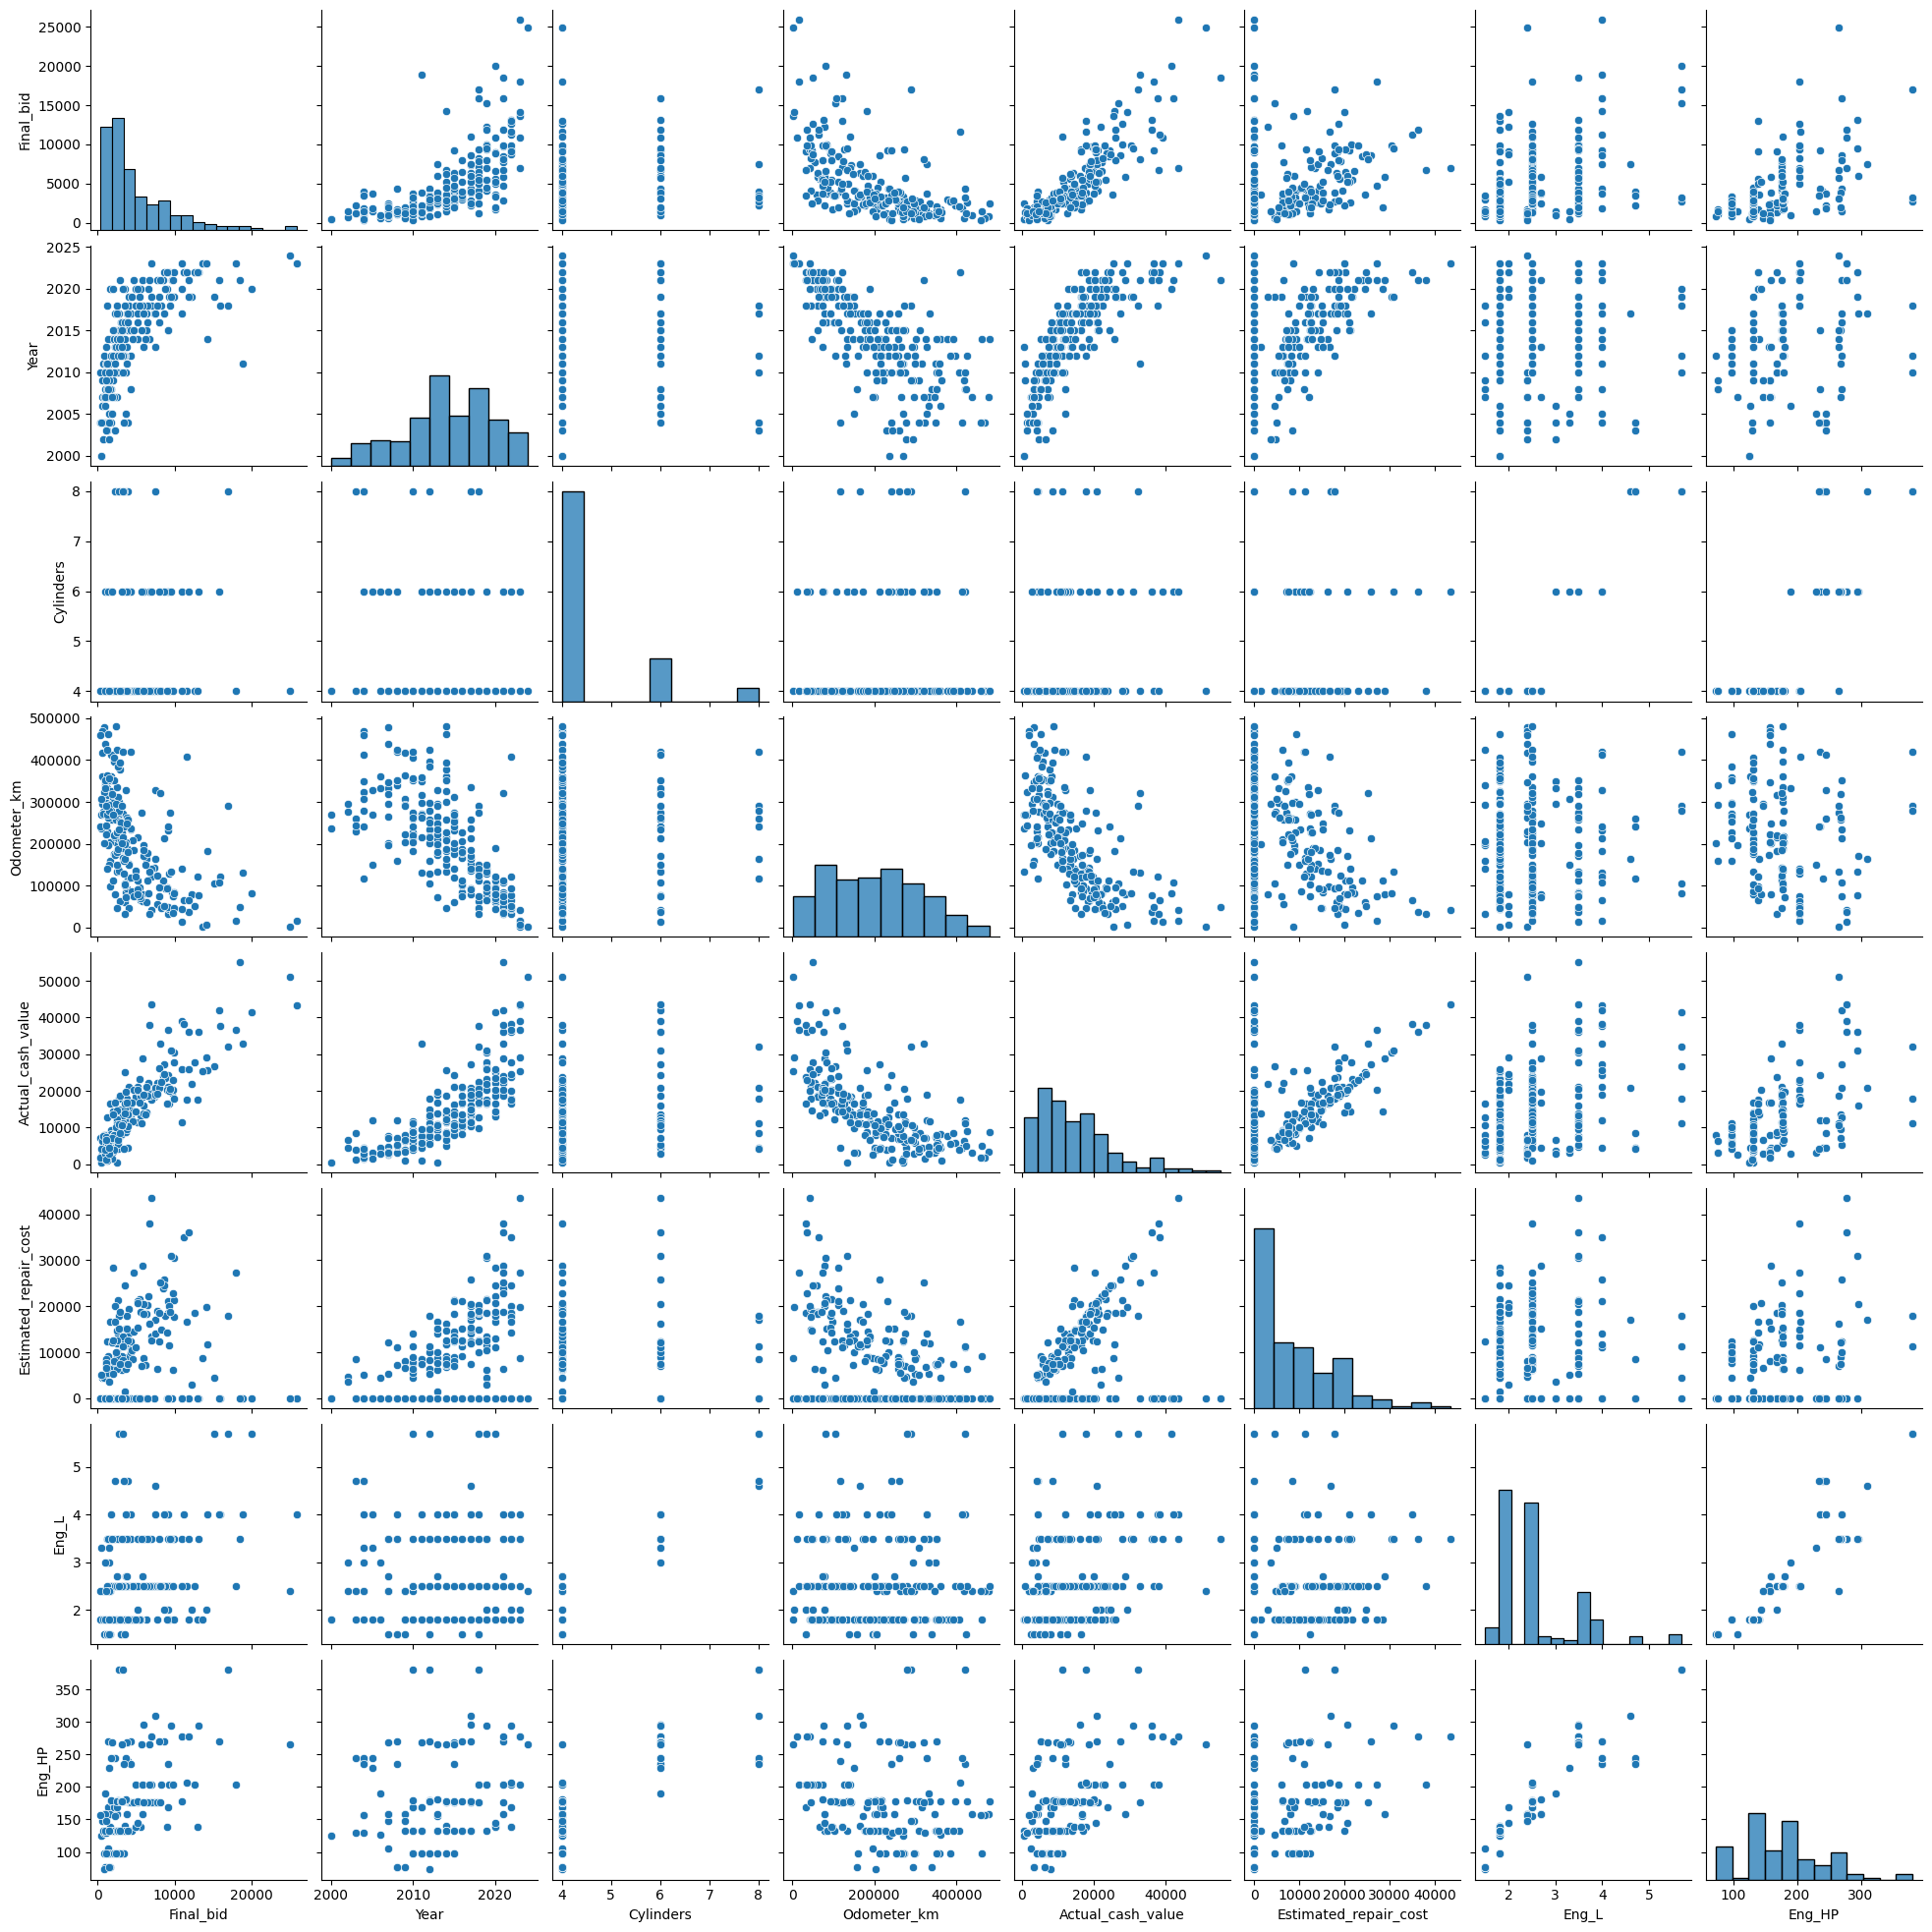

In [133]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# sns.pairplot(df, hue='Final_bid')
sns.pairplot(df)

# **Auction price prediction**

In [134]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# scaler = StandardScaler()  # normalizes data so they are in the same range

X = df[['Year', 'Primary damage', 'Secondary damage', 'Start code', 'Key', 'Model',  'Transmission', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost']]    # 'Cylinders',  'Eng_L'
y = df['Final_bid']

categorical = ['Primary damage', 'Secondary damage', 'Start code', 'Key', 'Model', 'Transmission']
numerical = ['Year', 'Odometer_km', 'Actual_cash_value', 'Estimated_repair_cost']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

model = RandomForestRegressor(n_estimators=100, random_state=42)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year', 'Odometer_km',
                                                   'Actual_cash_value',
                                                   'Estimated_repair_cost']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Primary damage',
                                                   'Secondary damage',
                                                   'Start code', 'Key', 'Model',
                                                   'Transmission'])])),
                ('model', RandomForestRegressor(random_state=42))])

Make a prediction

In [135]:
def predict_price(car_details):
    input_df = pd.DataFrame([car_details])
    prediction = pipeline.predict(input_df)
    return prediction[0]


to_be_predicted = {'Year': 2017,
                   'Primary damage': 'All over',
                   'Secondary damage': '',
                   'Start code': 'No information',  # stationary increases price??
                   'Key': 'Present',
                   'Model': 'Corolla',
                   'Transmission': 'Automatic',
                   'Odometer_km': 112930,  # higher mileage increases price??
                   'Actual_cash_value': 20817,
                   'Estimated_repair_cost': 10817
                   }

predicted_price = predict_price(to_be_predicted)
print(f'Predicted Price: ${predicted_price}')

Predicted Price: $8309.25


In [135]:
# ADD SERIES AND ENG_L TO PREDICTION, Fuel type
# check if manufact country affects price distribution
